## ODE for a double pendulum

We want to find the family of ODEs that describe the motion of a double pendulum.  This means we have two arms. The first arm is connected to a bearing, say, lying flat along a wall.  So the first arm has an angle parameter that gives the arm's angle 

<div style="display: inline-block; margin-right: 12px; margin-left: 100px">
<img src="doublepen.gif" width="300" height="300" class="alignleft"/> </div>

i.e. $m_1$ hangs on the first arm with angle $\theta_1$ from vertical.  $m_2$ hangs off the second arm, connected at the base of the first arm, with angle $\theta_2$ from vertical (you could use the angle from the first arm if you prefer).  Let's say the first arm has length $r_1$ and the second arm has length $r_2$.  We call the coefficients of friction at the top of the first arm $k_1$ and at the top of the second arm $k_2$.  We are assuming all the mass is concentrated at the base of the two arms, i.e. the arms themselves are massless. 

The ODEs of motion are rather tedious to work out (typically one sees this in a 3rd year classical mechanics course, for the purpose of this course it would be fine if you grabbed this information from the web). 

$$ (m_1+m_2)r_1^2\theta_1'' + m_2r_1r_2\cos(\theta_1-\theta_2)\theta_2'' + m_2r_1r_2\sin(\theta_1-\theta_2)(\theta_2')^2-k_2\theta_2' + (k_1+k_2)\theta_1' + (m_1+m_2)r_1g\sin\theta_1 = 0$$

$$m_2r_2^2\theta_2'' + m_2r_1r_2\cos(\theta_1-\theta_2) \theta_1'' - m_2r_1r_2\sin(\theta_1-\theta_2)(\theta_1')^2 +k_2\theta_2' - k_2\theta_1' + m_2r_2g\sin\theta_2 = 0$$

We can convert this into a matrix differential equation
$$\pmatrix{(m_1+m_2)r_1^2 & m_2r_1r_2\cos(\theta_1-\theta_2) \cr m_2r_1r_2\cos(\theta_1-\theta_2) & m_2r_2^2} \pmatrix{\theta_1'' \cr \theta_2''} = \pmatrix{-m_2r_1r_2\sin(\theta_1-\theta_2)(\theta_2')^2 -(k_1+k_2)\theta_1' + k_2\theta_2' - (m_1+m_2)r_1g\sin\theta_1 \cr +m_2r_1r_2\sin(\theta_1-\theta_2)(\theta_1')^2 + k_2\theta_1' - k_2\theta_2' - m_2r_2g\sin\theta_2}$$

Since the matrix is invertible (provided $m_1 \neq 0$) this allows for us to solve for $\theta_1''$ and $\theta_2''$.

I've implemented an algorithm to approximate solutions to the differential equation.  Notice that if you use Euler's method verbatim, energy is not conserved!  But if I switch to more stable methods, energy is closer to being conserved.  Can you find a method where energy is always conserved? 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

g=9.81 # why not? 

## this is our ODE.  It takes as input theta1, theta2, theta1', and theta2' and
## returns theta1'' and theta2''. It also needs r1,r2, m1,m2, k1,k2. 
## It incodes the above. 
def theODE(t1, t2, t1p, t2p, r1,r2, m1,m2, k1,k2):
    global g
    A = np.matrix( [[(m1+m2)*(r1**2), m2*r1*r2*np.cos(t1-t2)],[m2*r1*r2*np.cos(t1-t2), m2*(r2**2)]] )
    v = np.matrix( [-m2*r1*r2*np.sin(t1-t2)*(t2p**2) - (k1+k2)*t1p + k2*t2p - (m1+m2)*r1*g*np.sin(t1),
                    m2*r1*r2*np.sin(t1-t2)*(t1p**2) + k2*t1p - k2*t2p - m2*r2*g*np.sin(t2)]).T
    w = (A**(-1))*v
    return w[0,0], w[1,0]


In [45]:
## gradient of kinetic+potential energy wrt t1,t2,t1p,t2p in that order.
def gradE(m1,m2,r1,r2,t1,t2,t1p,t2p,g):
    return -m2*r1*r2*t1p*t2p*np.sin(t1-t2) + (m1+m2)*g*r1*np.sin(t1),\
            m2*r1*r2*t1p*t2p*np.sin(t1-t2) + m2*g*r2*np.sin(t2),\
            (m1+m2)*(r1**2)*t1p+m2*r1*r2*t2p*np.cos(t1-t2),\
            m2*(r2**2)*t2p+m2*r1*r2*t1p*np.cos(t1-t2)

def compE(m1,m2,r1,r2,t1,t2,t1p,t2p,g):
    return 0.5*m1*(r1*t1p)**2+0.5*m2*((r1*t1p)**2+(r2*t2p)**2) + \
            m2*r1*r2*t1p*t2p*np.cos(t1-t2) + \
            m1*g*r1*(1-np.cos(t1)) + m2*g*(r1+r2-r1*np.cos(t1)-r2*np.cos(t2))
        
def dEdt(k1,k2,t1p,t2p):
    return -0.5*(k2*(t1p-t2p)**2 + k1*t1p**2)

## I = interval of approximation. 
## n = number of steps
## t1 = initial value of theta1, t1p = initial value of theta1'
## t2 = initial value of theta2, t2p = initial value of theta2'
## method is a string describing which method of approximation you want to use
## eConst is a bool, True and it attempts to "constrain" the solution to the 
##  appropriate kinetic+potential energy level. False and you get a raw numerical
##  approximation, and unfortunately for bad methods like pure Euler, energy 
##  can increase -- a contradiction! 
##
## returns 5 objects:
## list of time values, list of theta1 values, list of theta2 values,
##  list of theta1' values, list of theta2' values
def eulerApprox(I, n, t1,t1p, t2,t2p, r1,r2, m1,m2, k1,k2, method, eConst):
    domArr = [I[0]]
    t1A = [t1]
    t1pA = [t1p]
    t2A = [t2]
    t2pA = [t2p]
    dt = (I[1]-I[0])/n
    for i in range(1,n):
        # Fighting with method choice, as most methods seem to run into lack-of-conservation-of-energy
        # troubles. 
        t1pp=0.0;t2pp=0.0; ## 2nd derivatives to compute below
        if method=="classic Euler":
            t1pp, t2pp = theODE(t1A[-1], t2A[-1], t1pA[-1], t2pA[-1], r1, r2, m1, m2, k1, k2)
        elif method=="midpt Euler":
            t1pp, t2pp = theODE(t1A[-1], t2A[-1], t1pA[-1], t2pA[-1], r1, r2, m1, m2, k1, k2)
            bt1pp, bt2pp = theODE(t1A[-1]+0.5*dt*t1pA[-1], t2A[-1]+0.5*dt*t2pA[-1], 
                              t1pA[-1]+0.5*dt*t1pp, t2pA[-1]+0.5*dt*t2pp, 
                              r1, r2, m1, m2, k1, k2)
            t1pp=bt1pp; t2pp=bt2pp;
        elif method=="backward Euler":
            t1pp, t2pp = theODE(t1A[-1], t2A[-1], t1pA[-1], t2pA[-1], r1, r2, m1, m2, k1, k2)
            bt1pp,bt2pp = theODE(t1A[-1] + dt*t1pA[-1], t2A[-1] + dt*t2pA[-1], 
                            t1pA[-1] + dt*t1pp, t2pA[-1] + dt*t2pp, r1, r2, m1, m2, k1, k2)
            t1pp=bt1pp; t2pp=bt2pp; ## end backward Euler
            
        t1N = t1A[-1]; t1pN = t1pA[-1]; t2N = t2A[-1]; t2pN = t2pA[-1];
        if eConst==True:
            #Energy-constrained Euler method. We modify the direction of flow by following
            # the gradient of the energy functional so that we are at the appropriate energy. 
            # dE supposed to be equal to -0.5(k2(t1p-t2p)**2 + k1*t1p**2) dt
            deltaE = compE(m1,m2,r1,r2,t1A[-1]+dt*t1pA[-1], t2A[-1]+dt*t2pA[-1],\
                           t1pA[-1]+dt*t1pp, t2pA[-1]+dt*t2pp,g) -\
                     compE(m1,m2,r1,r2,t1A[-1],t2A[-1],t1pA[-1],t2pA[-1],g)
            gt1,gt2,gt3,gt4 = gradE(m1,m2,r1,r2,t1A[-1]+dt*t1pA[-1], t2A[-1]+dt*t2pA[-1], t1pA[-1]+dt*t1pp, 
                      t2pA[-1]+dt*t2pp,g)
            ## add appropriate amounts of gt1,gt2,gt3,gt4 to make energy correct to first order. 
            de = dEdt(k1,k2,t1pA[-1], t2pA[-1])*dt ## how E is supposed to change.
            ## now we push back along the gradient...
            lgrad = np.sqrt(gt1**2+gt2**2+gt3**2+gt4**2)
            ## todo: perhaps put a check in here? 
            ## this is an improvement but it's not an excellent check on energy growth. 
            
            t1N += dt*t1pA[-1] + (gt1*(de-deltaE)/lgrad**2)
            t1pN += dt*t1pp + (gt2*(de-deltaE)/lgrad**2)
            t2N += dt*t2pA[-1] + (gt3*(de-deltaE)/lgrad**2)
            t2pN += dt*t2pp + (gt4*(de-deltaE)/lgrad**2)
        else:
            Dt = dt ## uncomment below two lines if you want adaptive step size.
            #mag = t1pp**2 + t2pp**2
            #if (mag > 4): Dt = dt/np.sqrt(mag)
            
            t1N = t1A[-1] + Dt*t1pA[-1]
            t1pN = t1pA[-1] + Dt*t1pp
        
            t2N = t2A[-1] + Dt*t2pA[-1]
            t2pN = t2pA[-1] + Dt*t2pp
        
        t1A.append(t1N);         t2A.append(t2N);
        t1pA.append(t1pN);       t2pA.append(t2pN);
        domArr.append(domArr[-1]+dt)
    return domArr, t1A, t2A, t1pA, t2pA

print(eulerApprox([0,0.2], 10, 0,1, 0,-1, 1,1, 1,1, 0.01,0.01, "classic Euler", True))


([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000001, 0.14, 0.16, 0.18], [0, 0.017849296543407889, 0.035219384605112314, 0.05252408311516131, 0.069621974014408783, 0.086244152252522466, 0.1021158219701372, 0.11699006255192049, 0.13065715062155669, 0.14294551314198464], [0, -0.024976391174915284, -0.048140516193218644, -0.069727231616944399, -0.089864153590037327, -0.10849948664432994, -0.12549544957256065, -0.14068833532007838, -0.1539191384405158, -0.1650476492931765], [1, 1.0001745946225264, 0.98726057175662529, 0.96162098305450028, 0.92407652656698702, 0.87576539311256052, 0.8180229720100366, 0.75226066832469385, 0.67985791037344512, 0.60208278275361304], [-1, -0.99859801434959361, -0.97788800072133131, -0.93932341817178766, -0.88441610794752967, -0.81490645657370753, -0.73274170018267426, -0.63995501854841841, -0.53853075984995269, -0.4302983202944195])


<IPython.core.display.Javascript object>


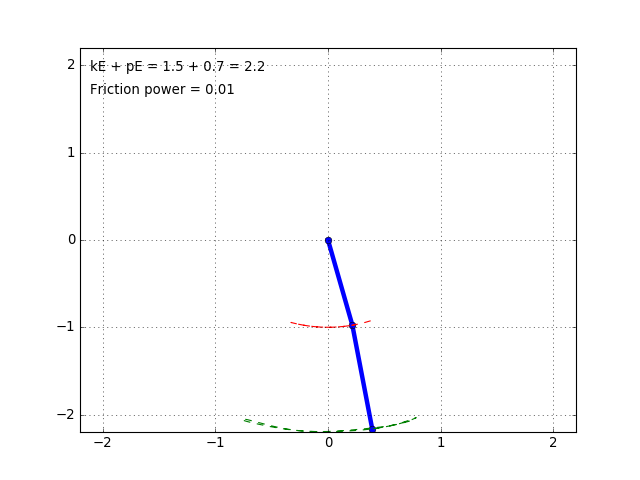

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib nbagg
#%matplotlib inline

## set initial values
t1=np.array([2.5]); t1p=np.array([0]);
t2=np.array([-0.2]); t2p=np.array([0]);
dt = 0.004
r1=1; r2=1.2;
m1=1; m2=1.2;
k1=0.06; k2=0.04; 

def x1(T1):
    global r1
    return r1*np.sin(T1)
def y1(T1):
    global r1
    return -r1*np.cos(T1)
def x2(T1,T2):
    global r2
    return x1(T1)+r2*np.sin(T2)
def y2(T1,T2):
    global r2
    return y1(T1) -r2*np.cos(T2)

def kEng():
    global m1,m2,r1,r2,t1,t2,t1p,t2p
    m1part = 0.5*m1*(r1*t1p[-1])**2
    m2part = 0.5*m2*( (r1*t1p[-1])**2 + (r2*t2p[-1])**2 ) + \
        m2*(r1*r2*t1p[-1]*t2p[-1] * np.cos(t1[-1]-t2[-1]) ) 
    return m1part + m2part
def pEng():
    global m1,m2,t1,t2,g,r1,r2
    return m1*g*(y1(t1[-1])+r1) + m2*g*(y2(t1[-1],t2[-1])+r1+r2)
def eDiss(): ## expected energy dissipation rate
    global k1,k2,t1p,t2p
    return 0.5*( k2*(t1p[-1]-t2p[-1])**2 + k1*(t1p[-1]**2) )

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-(r1+r2), r1+r2), ylim=(-(r1+r2), r1+r2) )
ax.grid()

line1, = ax.plot([],[],'o-', lw=4)
line2, = ax.plot([],[],'r--', lw=1)
line3, = ax.plot([],[],'g--', lw=1)

#en_template = 'kE + pE = %.1f + %.1f = %.1f'
en_text1 = ax.text(0.02,0.94, '', transform=ax.transAxes)
en_text2 = ax.text(0.02,0.88, '', transform=ax.transAxes)

def init():
    line1.set_data([],[])
    line2.set_data([],[])
    line3.set_data([],[])
    en_text1.set_text('')
    en_text2.set_text('')
    return line1, line2, line3, en_text1, en_text2,

def animate(i):
    ## update t1,t2
    global t1,t2, t1p,t2p, r1,r2, m1,m2, k1,k2, dt
    domA,t1A,t2A,t1pA,t2pA = eulerApprox([0,dt], 2, t1[-1], t1p[-1], t2[-1], t2p[-1],\
                                         r1, r2, m1, m2, k1, k2, "classic Euler", True)
    t1 = np.append(t1, t1A[-1])
    t2 = np.append(t2, t2A[-1])
    t1p = np.append(t1p, t1pA[-1])
    t2p = np.append(t2p, t2pA[-1])
    ## clear out the list of old values
    if len(t1) > 3000:
        t1p = t1p[-1000:]
        t2p = t2p[-1000:]
        t1 = t1[-1000:]
        t2 = t2[-1000:]
    ## update plot
    line1.set_data( [0,x1(t1[-1]), x2(t1[-1], t2[-1])], [0,y1(t1[-1]), y2(t1[-1],t2[-1])] )
    line2.set_data( x1(t1), y1(t1) )
    line3.set_data( x2(t1,t2), y2(t1, t2))
    E = kEng() + pEng()
        
    en_text1.set_text('kE + pE = %.1f + %.1f = %.1f' % (kEng(), pEng(), E) )
    en_text2.set_text('Friction power = %.2f' % eDiss())
    
    return line1, line2, line3, en_text1, en_text2,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                              interval=1, blit=True)
plt.show()